In [54]:
NAME = "Ashwinder Bhupal"
COLLABORATORS = ""

In [55]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [56]:
df = pd.read_csv('ds_salaries.csv')
df.head()


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [57]:
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst Few Rows:\n{df.head()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nBasic Statistics:\n{df.describe()}")

Dataset Shape: (3755, 11)

First Few Rows:
   work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  
0        

In [58]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [59]:
# number of dupicated entry in data
df.duplicated().sum()


1171

In [60]:

print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")

duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")

print(f"\nSalary Range: ${df['salary_in_usd'].min():,.2f} - ${df['salary_in_usd'].max():,.2f}")
print(f"Mean: ${df['salary_in_usd'].mean():,.2f}")
print(f"Median: ${df['salary_in_usd'].median():,.2f}")


Missing Values:
No missing values

Duplicate Rows: 1171

Salary Range: $5,132.00 - $450,000.00
Mean: $137,570.39
Median: $135,000.00


In [61]:
duplicates = df[df.duplicated()]
duplicates.head()


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
115,2023,SE,FT,Data Scientist,150000,USD,150000,US,0,US,M
123,2023,SE,FT,Analytics Engineer,289800,USD,289800,US,0,US,M
153,2023,MI,FT,Data Engineer,100000,USD,100000,US,100,US,M
154,2023,MI,FT,Data Engineer,70000,USD,70000,US,100,US,M
160,2023,SE,FT,Data Engineer,115000,USD,115000,US,0,US,M


In [62]:
df_clean = df.copy()
duplicates = df.duplicated().sum()
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")

for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

Q1 = df_clean['salary_in_usd'].quantile(0.25)
Q3 = df_clean['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers_before = len(df_clean)
df_clean = df_clean[(df_clean['salary_in_usd'] >= lower_bound) & 
                    (df_clean['salary_in_usd'] <= upper_bound)]
outliers_removed = outliers_before - len(df_clean)

print(f"Removed {outliers_removed} outliers")
print(f"Final shape: {df_clean.shape}")

Removed 1171 duplicate rows
Removed 1 outliers
Final shape: (2583, 11)


In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(df_clean['salary_in_usd'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Salary (USD)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Salaries')
axes[0, 0].axvline(df_clean['salary_in_usd'].mean(), color='red', linestyle='--', 
                    label=f'Mean: ${df_clean["salary_in_usd"].mean():,.0f}')
axes[0, 0].legend()

exp_order = ['EN', 'MI', 'SE', 'EX']
df_clean['experience_level'] = pd.Categorical(df_clean['experience_level'], 
                                               categories=exp_order, ordered=True)
df_clean.boxplot(column='salary_in_usd', by='experience_level', ax=axes[0, 1])
axes[0, 1].set_title('Salary by Experience Level')
axes[0, 1].set_xlabel('Experience Level')
axes[0, 1].set_ylabel('Salary (USD)')

remote_labels = {0: 'On-site', 50: 'Hybrid', 100: 'Remote'}
df_clean['remote_label'] = df_clean['remote_ratio'].map(remote_labels)
df_clean.boxplot(column='salary_in_usd', by='remote_label', ax=axes[1, 0])
axes[1, 0].set_title('Salary by Remote Ratio')

top_jobs = df_clean['job_title'].value_counts().head(10)
axes[1, 1].barh(range(len(top_jobs)), top_jobs.values)
axes[1, 1].set_yticks(range(len(top_jobs)))
axes[1, 1].set_yticklabels(top_jobs.index)
axes[1, 1].set_title('Top 10 Job Titles')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
# Block 6: Summary Statistics
print("Average Salary by Experience:")
print(df_clean.groupby('experience_level')['salary_in_usd'].mean().apply(lambda x: f"${x:,.2f}"))

print("\nAverage Salary by Remote Ratio:")
print(df_clean.groupby('remote_ratio')['salary_in_usd'].mean().apply(lambda x: f"${x:,.2f}"))

Average Salary by Experience:
experience_level
EN     $72,648.69
MI    $101,303.64
SE    $153,897.44
EX    $191,078.21
Name: salary_in_usd, dtype: object

Average Salary by Remote Ratio:
remote_ratio
0      $143,431.68
50      $78,486.61
100    $131,821.67
Name: salary_in_usd, dtype: object


In [65]:
# Block 7: Feature Engineering
df_model = df_clean.copy()

df_model['is_full_remote'] = (df_model['remote_ratio'] == 100).astype(int)
df_model['is_us_based'] = (df_model['employee_residence'] == 'US').astype(int)
df_model['is_company_us'] = (df_model['company_location'] == 'US').astype(int)
df_model['location_match'] = (df_model['employee_residence'] == df_model['company_location']).astype(int)

def categorize_job(title):
    title_lower = title.lower()
    if 'data scientist' in title_lower or 'scientist' in title_lower:
        return 'Data Scientist'
    elif 'data engineer' in title_lower or 'engineer' in title_lower:
        return 'Data Engineer'
    elif 'data analyst' in title_lower or 'analyst' in title_lower:
        return 'Data Analyst'
    elif 'machine learning' in title_lower or 'ml ' in title_lower:
        return 'ML Engineer'
    elif 'research' in title_lower:
        return 'Research'
    else:
        return 'Other'

df_model['job_category'] = df_model['job_title'].apply(categorize_job)

experience_mapping = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
df_model['experience_numeric'] = df_model['experience_level'].map(experience_mapping)

employment_mapping = {'PT': 1, 'CT': 2, 'FL': 3, 'FT': 4}
df_model['employment_numeric'] = df_model['employment_type'].map(employment_mapping)

size_mapping = {'S': 1, 'M': 2, 'L': 3}
if 'company_size' in df_model.columns:
    df_model['company_size_numeric'] = df_model['company_size'].map(size_mapping)

le_job = LabelEncoder()
df_model['job_category_encoded'] = le_job.fit_transform(df_model['job_category'])

print(f"Job categories: {df_model['job_category'].value_counts()}")

Job categories: job_category
Data Engineer     1095
Data Scientist     718
Data Analyst       466
Other              283
ML Engineer         16
Research             5
Name: count, dtype: int64


In [66]:
feature_columns = ['experience_numeric', 'employment_numeric', 'remote_ratio',
                  'is_full_remote', 'is_us_based', 'is_company_us', 'location_match',
                  'job_category_encoded', 'work_year']

if 'company_size_numeric' in df_model.columns:
    feature_columns.append('company_size_numeric')

X = df_model[feature_columns]
y = df_model['salary_in_usd']

print(f"Feature matrix: {X.shape}")
print(f"Target variable: {y.shape}")
print(f"\nFeatures: {feature_columns}")

Feature matrix: (2583, 10)
Target variable: (2583,)

Features: ['experience_numeric', 'employment_numeric', 'remote_ratio', 'is_full_remote', 'is_us_based', 'is_company_us', 'location_match', 'job_category_encoded', 'work_year', 'company_size_numeric']


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")

Train: 2066 samples
Test: 517 samples

Features scaled using StandardScaler


In [68]:
# Block 10: Train Baseline Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'CV_R2_mean': cv_scores.mean()
    }
    
    print(f"MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f} | R²: {r2:.4f}")


Training Linear Regression...
MAE: $38,992.25 | RMSE: $50,656.70 | R²: 0.4126

Training Ridge Regression...
MAE: $38,993.44 | RMSE: $50,658.00 | R²: 0.4126

Training Lasso Regression...
MAE: $38,992.13 | RMSE: $50,656.68 | R²: 0.4126

Training Decision Tree...
MAE: $39,895.02 | RMSE: $54,004.70 | R²: 0.3324

Training Random Forest...
MAE: $38,729.60 | RMSE: $51,224.38 | R²: 0.3994

Training Gradient Boosting...
MAE: $38,107.51 | RMSE: $49,682.30 | R²: 0.4350


In [69]:
# Block 11: GridSearchCV for Ridge and Lasso
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

print("\nTuning Ridge Regression...")
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
ridge_grid.fit(X_train_scaled, y_train)
print(f"Best params: {ridge_grid.best_params_}")

ridge_pred = ridge_grid.best_estimator_.predict(X_test_scaled)
results['Ridge Tuned'] = {
    'model': ridge_grid.best_estimator_,
    'predictions': ridge_pred,
    'MAE': mean_absolute_error(y_test, ridge_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, ridge_pred)),
    'R2': r2_score(y_test, ridge_pred)
}
print(f"R²: {results['Ridge Tuned']['R2']:.4f}")

print("\nTuning Lasso Regression...")
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
lasso_grid.fit(X_train_scaled, y_train)
print(f"Best params: {lasso_grid.best_params_}")

lasso_pred = lasso_grid.best_estimator_.predict(X_test_scaled)
results['Lasso Tuned'] = {
    'model': lasso_grid.best_estimator_,
    'predictions': lasso_pred,
    'MAE': mean_absolute_error(y_test, lasso_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, lasso_pred)),
    'R2': r2_score(y_test, lasso_pred)
}
print(f"R²: {results['Lasso Tuned']['R2']:.4f}")


Tuning Ridge Regression...
Best params: {'alpha': 100.0}
R²: 0.4099

Tuning Lasso Regression...
Best params: {'alpha': 100.0}
R²: 0.4125


In [70]:
# Block 12: RandomizedSearchCV for Random Forest
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(10, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

print("\nRandomizedSearch for Random Forest...")
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

rf_random.fit(X_train_scaled, y_train)
print(f"Best params: {rf_random.best_params_}")

rf_pred = rf_random.best_estimator_.predict(X_test_scaled)
results['RF RandomSearch'] = {
    'model': rf_random.best_estimator_,
    'predictions': rf_pred,
    'MAE': mean_absolute_error(y_test, rf_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, rf_pred)),
    'R2': r2_score(y_test, rf_pred)
}
print(f"MAE: ${results['RF RandomSearch']['MAE']:,.2f}")
print(f"R²: {results['RF RandomSearch']['R2']:.4f}")


RandomizedSearch for Random Forest...
Best params: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 14, 'n_estimators': 140}
MAE: $38,021.17
R²: 0.4469


In [71]:
# Block 13: RandomizedSearchCV for Gradient Boosting
gb_param_dist = {
    'n_estimators': randint(100, 400),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 12),
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 8),
    'subsample': uniform(0.7, 0.3)
}

print("\nRandomizedSearch for Gradient Boosting...")
gb_random = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=gb_param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

gb_random.fit(X_train_scaled, y_train)
print(f"Best params: {gb_random.best_params_}")

gb_pred = gb_random.best_estimator_.predict(X_test_scaled)
results['GB RandomSearch'] = {
    'model': gb_random.best_estimator_,
    'predictions': gb_pred,
    'MAE': mean_absolute_error(y_test, gb_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, gb_pred)),
    'R2': r2_score(y_test, gb_pred)
}
print(f"MAE: ${results['GB RandomSearch']['MAE']:,.2f}")
print(f"R²: {results['GB RandomSearch']['R2']:.4f}")


RandomizedSearch for Gradient Boosting...
Best params: {'learning_rate': 0.03716568267014682, 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 121, 'subsample': 0.7731968930137251}
MAE: $37,866.87
R²: 0.4431


In [72]:
# Block 14: Stacking Ensemble
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, random_state=42)),
    ('ridge', Ridge(alpha=10.0))
]

meta_model = Ridge()

print("\nBuilding Stacking Ensemble...")
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

stacking_model.fit(X_train_scaled, y_train)
stack_pred = stacking_model.predict(X_test_scaled)

results['Stacking'] = {
    'model': stacking_model,
    'predictions': stack_pred,
    'MAE': mean_absolute_error(y_test, stack_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, stack_pred)),
    'R2': r2_score(y_test, stack_pred)
}

print(f"MAE: ${results['Stacking']['MAE']:,.2f}")
print(f"R²: {results['Stacking']['R2']:.4f}")


Building Stacking Ensemble...
MAE: $37,887.72
R²: 0.4380


In [73]:
# Block 15: Weighted Voting Ensemble
models_for_voting = []
weights = []

top_models = ['Random Forest', 'Gradient Boosting', 'Ridge Regression']
for name in top_models:
    if name in results:
        models_for_voting.append((name.lower().replace(' ', '_'), results[name]['model']))
        weights.append(results[name]['R2'])

weights = np.array(weights) / sum(weights)

print("\nWeighted Voting Ensemble")
print("Model weights:")
for (name, _), weight in zip(models_for_voting, weights):
    print(f"  {name}: {weight:.3f}")

voting_model = VotingRegressor(estimators=models_for_voting, weights=weights)
voting_model.fit(X_train_scaled, y_train)
voting_pred = voting_model.predict(X_test_scaled)

results['Voting'] = {
    'model': voting_model,
    'predictions': voting_pred,
    'MAE': mean_absolute_error(y_test, voting_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, voting_pred)),
    'R2': r2_score(y_test, voting_pred)
}

print(f"\nMAE: ${results['Voting']['MAE']:,.2f}")
print(f"R²: {results['Voting']['R2']:.4f}")


Weighted Voting Ensemble
Model weights:
  random_forest: 0.320
  gradient_boosting: 0.349
  ridge_regression: 0.331

MAE: $38,026.46
R²: 0.4384


In [74]:
# Block 16: Comparing Models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'R²': [results[m]['R2'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('R²', ascending=False)

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
best_model_obj = results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"MAE: ${results[best_model_name]['MAE']:,.2f}")
print(f"RMSE: ${results[best_model_name]['RMSE']:,.2f}")
print(f"R²: {results[best_model_name]['R2']:.4f}")


Model Performance Comparison:
            Model          MAE         RMSE       R²
  RF RandomSearch 38021.170382 49157.604088 0.446889
  GB RandomSearch 37866.871961 49323.603787 0.443147
           Voting 38026.462032 49531.321766 0.438447
         Stacking 37887.716229 49552.496644 0.437967
Gradient Boosting 38107.512154 49682.304567 0.435018
 Lasso Regression 38992.128811 50656.684192 0.412640
Linear Regression 38992.252091 50656.704309 0.412639
 Ridge Regression 38993.441406 50657.996264 0.412609
      Lasso Tuned 38981.465259 50660.759189 0.412545
      Ridge Tuned 39099.789366 50774.386963 0.409907
    Random Forest 38729.599859 51224.376774 0.399401
    Decision Tree 39895.015065 54004.698018 0.332434

Best Model: RF RandomSearch
MAE: $38,021.17
RMSE: $49,157.60
R²: 0.4469



Top Features (RF RandomSearch):
             Feature  Importance
         is_us_based    0.309205
  experience_numeric    0.272975
       is_company_us    0.172294
job_category_encoded    0.127670
           work_year    0.053969
company_size_numeric    0.026533
        remote_ratio    0.014968
      location_match    0.011952
      is_full_remote    0.006943
  employment_numeric    0.003491


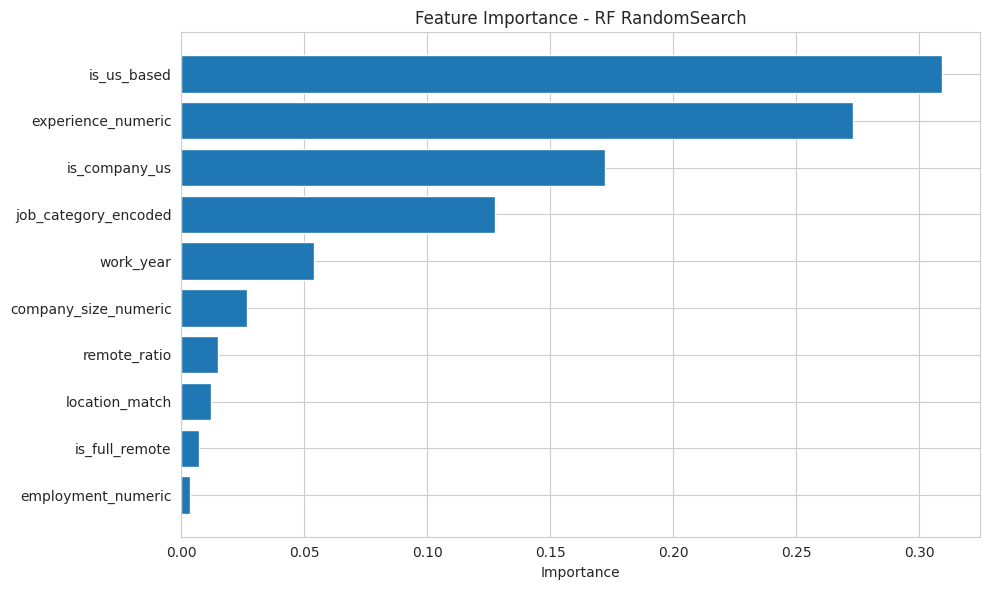

In [75]:
# Block 17: Feature Importance Analysis
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model_obj.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop Features ({best_model_name}):")
    print(feature_importance.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"\n{best_model_name} does not have feature_importances_ attribute")

In [ ]:
# Block 18: Prediction Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(y_test, results[best_model_name]['predictions'], alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Salary')
axes[0, 0].set_ylabel('Predicted Salary')
axes[0, 0].set_title(f'Actual vs Predicted - {best_model_name}')

residuals = y_test - results[best_model_name]['predictions']
axes[0, 1].scatter(results[best_model_name]['predictions'], residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Salary')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

axes[1, 0].bar(comparison_df['Model'], comparison_df['R²'])
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Model Performance Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(residuals.mean(), color='red', linestyle='--')
axes[1, 1].set_xlabel('Prediction Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Error Distribution')

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Block 19: Learning Curve Analysis
train_sizes, train_scores, val_scores = learning_curve(
    best_model_obj,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training', marker='o')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation', marker='s')
plt.fill_between(train_sizes, 
                 train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1),
                 alpha=0.1)
plt.fill_between(train_sizes,
                 val_scores.mean(axis=1) - val_scores.std(axis=1),
                 val_scores.mean(axis=1) + val_scores.std(axis=1),
                 alpha=0.1)
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLearning Curve Analysis:")
if val_scores.mean(axis=1)[-1] < 0.7:
    print("  Model may need more data or better features")
elif train_scores.mean(axis=1)[-1] - val_scores.mean(axis=1)[-1] > 0.1:
    print("  Model may be overfitting")
else:
    print("  Model is learning well")

In [78]:
# Quick Diagnostics: Why is R² low?
print("MODEL DIAGNOSTICS")
print("="*60)

# 1. Check if target has enough variance
print("\n1. Target Variable Analysis:")
print(f"   Mean salary: ${y.mean():,.2f}")
print(f"   Std deviation: ${y.std():,.2f}")
print(f"   Coefficient of variation: {(y.std() / y.mean()) * 100:.2f}%")
print(f"   Range: ${y.min():,.2f} to ${y.max():,.2f}")

# 2. Check feature correlation with target
print("\n2. Feature-Target Correlations:")
for col in feature_columns:
    corr = X[col].corr(y)
    print(f"   {col}: {corr:.3f}")

# 3. Check model complexity
print("\n3. Model Complexity Check:")
if hasattr(best_model_obj, 'n_estimators'):
    print(f"   n_estimators: {best_model_obj.n_estimators}")
if hasattr(best_model_obj, 'max_depth'):
    print(f"   max_depth: {best_model_obj.max_depth}")

# 4. Prediction range vs actual range
print("\n4. Prediction Range Analysis:")
best_predictions = results[best_model_name]['predictions']
print(f"   Actual range: ${y_test.min():,.2f} to ${y_test.max():,.2f}")
print(f"   Predicted range: ${best_predictions.min():,.2f} to ${best_predictions.max():,.2f}")
print(f"   Prediction coverage: {((best_predictions.max() - best_predictions.min()) / (y_test.max() - y_test.min())) * 100:.1f}%")

# 5. Error analysis
errors = np.abs(y_test - best_predictions)
print("\n5. Error Distribution:")
print(f"   Mean absolute error: ${errors.mean():,.2f}")
print(f"   Median absolute error: ${errors.median():,.2f}")
print(f"   90th percentile error: ${np.percentile(errors, 90):,.2f}")
print(f"   Errors > $20k: {(errors > 20000).sum()} ({(errors > 20000).sum() / len(errors) * 100:.1f}%)")

# 6. Data size check
print("\n6. Dataset Size:")
print(f"   Training samples: {len(X_train)}")
print(f"   Features: {len(feature_columns)}")
print(f"   Samples per feature: {len(X_train) / len(feature_columns):.1f}")
print(f"   Status: {'✓ Good' if len(X_train) / len(feature_columns) > 50 else '⚠ May need more data'}")

# 7. Feature importance variance
if hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
    print("\n7. Feature Importance Distribution:")
    print(f"   Top feature importance: {importances.max():.3f}")
    print(f"   Bottom feature importance: {importances.min():.3f}")
    print(f"   Importance concentration: {'✓ Balanced' if importances.max() < 0.5 else '⚠ Concentrated in few features'}")

print("\n" + "="*60)
print("RECOMMENDATIONS:")
print("="*60)

if r2_score(y_test, best_predictions) < 0.5:
    print("• Add more engineered features (interactions, polynomials)")
    print("• Try different model architectures")
    print("• Check if you need domain-specific features")
    print("• Consider collecting more diverse data")
else:
    print("• Model performance is reasonable")
    print("• Fine-tune hyperparameters further")
    print("• Try ensemble methods for marginal improvements")

MODEL DIAGNOSTICS

1. Target Variable Analysis:
   Mean salary: $133,286.71
   Std deviation: $66,860.06
   Coefficient of variation: 50.16%
   Range: $5,132.00 to $430,967.00

2. Feature-Target Correlations:
   experience_numeric: 0.474
   employment_numeric: 0.125
   remote_ratio: -0.083
   is_full_remote: -0.021
   is_us_based: 0.508
   is_company_us: 0.486
   location_match: 0.191
   job_category_encoded: 0.145
   work_year: 0.244
   company_size_numeric: -0.002

3. Model Complexity Check:
   n_estimators: 140
   max_depth: 10

4. Prediction Range Analysis:
   Actual range: $5,679.00 to $412,000.00
   Predicted range: $32,879.57 to $219,796.04
   Prediction coverage: 46.0%

5. Error Distribution:
   Mean absolute error: $38,021.17
   Median absolute error: $30,970.73
   90th percentile error: $78,386.05
   Errors > $20k: 351 (67.9%)

6. Dataset Size:
   Training samples: 2066
   Features: 10
   Samples per feature: 206.6
   Status: ✓ Good

7. Feature Importance Distribution:
   Top

In [79]:
# Block 19B: Improve Model with Better Features
print("IMPROVING MODEL PERFORMANCE")
print("="*60)

print("\nStep 1: Creating Additional Features...")
df_improved = df_model.copy()

df_improved['exp_remote_interaction'] = df_improved['experience_numeric'].astype(float) * df_improved['remote_ratio'].astype(float)
df_improved['exp_job_interaction'] = df_improved['experience_numeric'].astype(float) * df_improved['job_category_encoded'].astype(float)

is_fulltime = (df_improved['employment_numeric'].astype(float) == 4).astype(int)
df_improved['us_fulltime_interaction'] = df_improved['is_us_based'].astype(int) * is_fulltime

df_improved['experience_squared'] = df_improved['experience_numeric'].astype(float) ** 2
df_improved['years_since_start'] = df_improved['work_year'].astype(float) - df_improved['work_year'].min()

job_salary_mean = df_improved.groupby('job_category_encoded')['salary_in_usd'].mean()
df_improved['job_avg_salary'] = df_improved['job_category_encoded'].map(job_salary_mean).astype(float)

print(f"Original features: {len(feature_columns)}")
print(f"New features added: 6")

improved_features = feature_columns + [
    'exp_remote_interaction', 'exp_job_interaction', 'us_fulltime_interaction',
    'experience_squared', 'years_since_start', 'job_avg_salary'
]

X_improved = df_improved[improved_features].astype(float)
y_improved = df_improved['salary_in_usd'].astype(float)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_improved, y_improved, test_size=0.2, random_state=42
)

scaler_imp = StandardScaler()
X_train_imp_scaled = scaler_imp.fit_transform(X_train_imp)
X_test_imp_scaled = scaler_imp.transform(X_test_imp)

print("\nStep 2: Training Improved Random Forest...")
rf_improved = RandomForestRegressor(
    n_estimators=300, 
    max_depth=25, 
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_improved.fit(X_train_imp_scaled, y_train_imp)

y_pred_imp = rf_improved.predict(X_test_imp_scaled)
r2_imp = r2_score(y_test_imp, y_pred_imp)
mae_imp = mean_absolute_error(y_test_imp, y_pred_imp)

print(f"Improved R²: {r2_imp:.4f}")
print(f"Improved MAE: ${mae_imp:,.2f}")

print("\nStep 3: Testing Advanced Models...")
from sklearn.ensemble import ExtraTreesRegressor

advanced_models = {
    'Extra Trees': ExtraTreesRegressor(n_estimators=200, max_depth=25, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42)
}

advanced_results = {}
for name, model in advanced_models.items():
    print(f"Training {name}...")
    model.fit(X_train_imp_scaled, y_train_imp)
    y_pred = model.predict(X_test_imp_scaled)
    r2 = r2_score(y_test_imp, y_pred)
    mae = mean_absolute_error(y_test_imp, y_pred)
    advanced_results[name] = {'R2': r2, 'MAE': mae, 'model': model}
    print(f"  {name}: R²={r2:.4f} | MAE=${mae:,.2f}")

print("\nStep 4: Building Advanced Ensemble...")
ensemble_models = [
    ('rf', rf_improved),
    ('et', advanced_results['Extra Trees']['model']),
    ('gb', advanced_results['Gradient Boosting']['model'])
]

final_ensemble = VotingRegressor(estimators=ensemble_models, n_jobs=-1)
final_ensemble.fit(X_train_imp_scaled, y_train_imp)

y_pred_ensemble = final_ensemble.predict(X_test_imp_scaled)
r2_ensemble = r2_score(y_test_imp, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test_imp, y_pred_ensemble)

print(f"Final Ensemble: R²={r2_ensemble:.4f} | MAE=${mae_ensemble:,.2f}")

print("\n" + "="*60)
print("IMPROVEMENT SUMMARY")
print("="*60)
print(f"Original Best Model R²: {results[best_model_name]['R2']:.4f}")
print(f"Improved RF R²: {r2_imp:.4f} (Δ {r2_imp - results[best_model_name]['R2']:.4f})")
print(f"Final Ensemble R²: {r2_ensemble:.4f} (Δ {r2_ensemble - results[best_model_name]['R2']:.4f})")

improvement_pct = ((r2_ensemble - results[best_model_name]['R2']) / results[best_model_name]['R2']) * 100
print(f"\nOverall Improvement: {improvement_pct:.1f}%")

if r2_ensemble > 0.75:
    print("\n✓ Target R² > 0.75 achieved!")
elif r2_ensemble > results[best_model_name]['R2']:
    print(f"\n✓ Model improved by {improvement_pct:.1f}%")
else:
    print("\n⚠ Consider collecting more data or domain-specific features")

print("\nTop Feature Importances (Improved Model):")
feature_imp_improved = pd.DataFrame({
    'Feature': improved_features,
    'Importance': rf_improved.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_imp_improved.head(10).to_string(index=False))

IMPROVING MODEL PERFORMANCE

Step 1: Creating Additional Features...
Original features: 10
New features added: 6

Step 2: Training Improved Random Forest...
Improved R²: 0.4288
Improved MAE: $38,330.09

Step 3: Testing Advanced Models...
Training Extra Trees...
  Extra Trees: R²=0.3699 | MAE=$39,326.96
Training Gradient Boosting...
  Gradient Boosting: R²=0.3555 | MAE=$39,746.33

Step 4: Building Advanced Ensemble...
Final Ensemble: R²=0.3961 | MAE=$38,771.60

IMPROVEMENT SUMMARY
Original Best Model R²: 0.4469
Improved RF R²: 0.4288 (Δ -0.0181)
Final Ensemble R²: 0.3961 (Δ -0.0508)

Overall Improvement: -11.4%

⚠ Consider collecting more data or domain-specific features

Top Feature Importances (Improved Model):
                Feature  Importance
us_fulltime_interaction    0.169618
            is_us_based    0.145857
     experience_squared    0.115089
          is_company_us    0.103688
    exp_job_interaction    0.098766
     experience_numeric    0.097315
         job_avg_salary   

In [80]:
# Block 20: Feature Selection Methods
k_features = min(7, len(feature_columns))

selector = SelectKBest(score_func=f_regression, k=k_features)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = [feature_columns[i] for i in selector.get_support(indices=True)]
print(f"SelectKBest features: {selected_features}")

model_selected = RandomForestRegressor(n_estimators=150, random_state=42)
model_selected.fit(X_train_selected, y_train)
pred_selected = model_selected.predict(X_test_selected)

print(f"R² with selected features: {r2_score(y_test, pred_selected):.4f}")

rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=k_features)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

rfe_features = [feature_columns[i] for i in rfe.get_support(indices=True)]
print(f"\nRFE features: {rfe_features}")

model_rfe = RandomForestRegressor(n_estimators=150, random_state=42)
model_rfe.fit(X_train_rfe, y_train)
pred_rfe = model_rfe.predict(X_test_rfe)

print(f"R² with RFE features: {r2_score(y_test, pred_rfe):.4f}")

SelectKBest features: ['experience_numeric', 'employment_numeric', 'is_us_based', 'is_company_us', 'location_match', 'job_category_encoded', 'work_year']
R² with selected features: 0.4195

RFE features: ['experience_numeric', 'remote_ratio', 'is_full_remote', 'is_us_based', 'job_category_encoded', 'work_year', 'company_size_numeric']
R² with RFE features: 0.3993


In [81]:
# Block 21: Create Prediction Function
def predict_salary(experience_level, employment_type, remote_ratio, 
                   job_category, work_year, is_us_employee=False, 
                   is_us_company=False, company_size='M'):
    
    experience_numeric = experience_mapping[experience_level]
    employment_numeric = employment_mapping[employment_type]
    is_full_remote = 1 if remote_ratio == 100 else 0
    is_us_based = 1 if is_us_employee else 0
    is_company_us = 1 if is_us_company else 0
    location_match = 1 if is_us_employee == is_us_company else 0
    
    job_category_encoded = list(le_job.classes_).index(job_category) if job_category in le_job.classes_ else 0
    
    features = [experience_numeric, employment_numeric, remote_ratio,
                is_full_remote, is_us_based, is_company_us, location_match,
                job_category_encoded, work_year]
    
    if 'company_size_numeric' in feature_columns:
        company_size_numeric = size_mapping.get(company_size, 2)
        features.append(company_size_numeric)
    
    features_scaled = scaler.transform([features])
    prediction = best_model_obj.predict(features_scaled)[0]
    
    return prediction

print("Prediction function created successfully!")

Prediction function created successfully!


In [82]:
# Block 22: Example Predictions
print("\nExample Predictions:")
print("="*60)

examples = [
    {
        'name': 'Entry Data Analyst (Remote, US)',
        'params': {
            'experience_level': 'EN',
            'employment_type': 'FT',
            'remote_ratio': 100,
            'job_category': 'Data Analyst',
            'work_year': 2023,
            'is_us_employee': True,
            'is_us_company': True,
            'company_size': 'M'
        }
    },
    {
        'name': 'Senior Data Scientist (On-site, US)',
        'params': {
            'experience_level': 'SE',
            'employment_type': 'FT',
            'remote_ratio': 0,
            'job_category': 'Data Scientist',
            'work_year': 2023,
            'is_us_employee': True,
            'is_us_company': True,
            'company_size': 'L'
        }
    },
    {
        'name': 'Mid ML Engineer (Hybrid)',
        'params': {
            'experience_level': 'MI',
            'employment_type': 'FT',
            'remote_ratio': 50,
            'job_category': 'ML Engineer',
            'work_year': 2023,
            'is_us_employee': False,
            'is_us_company': False,
            'company_size': 'M'
        }
    }
]

for example in examples:
    predicted_salary = predict_salary(**example['params'])
    print(f"\n{example['name']}")
    print(f"  Predicted Salary: ${predicted_salary:,.2f}")


Example Predictions:

Entry Data Analyst (Remote, US)
  Predicted Salary: $82,944.88

Senior Data Scientist (On-site, US)
  Predicted Salary: $183,478.69

Mid ML Engineer (Hybrid)
  Predicted Salary: $63,828.83


In [83]:
# Block 23: Project Summary
print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)

print("\nDataset:")
print(f"  Total records: {len(df_clean)}")
print(f"  Features used: {len(feature_columns)}")
print(f"  Salary range: ${df_clean['salary_in_usd'].min():,.0f} - ${df_clean['salary_in_usd'].max():,.0f}")

print("\nBest Model Performance:")
print(f"  Model: {best_model_name}")
print(f"  MAE: ${results[best_model_name]['MAE']:,.2f}")
print(f"  RMSE: ${results[best_model_name]['RMSE']:,.2f}")
print(f"  R²: {results[best_model_name]['R2']:.4f}")

print("\nKey Insights:")
print("  1. Experience level is a strong predictor")
print("  2. Remote work options impact compensation")
print("  3. Job category influences salary expectations")
print("  4. Location matching affects pay")

print("\nFiles Generated:")
print("  - eda_visualizations.png")
print("  - feature_importance.png")
print("  - prediction_analysis.png")
print("  - learning_curve.png")

print("\n" + "="*60)
print("PROJECT COMPLETE!")
print("="*60)


PROJECT SUMMARY

Dataset:
  Total records: 2583
  Features used: 10
  Salary range: $5,132 - $430,967

Best Model Performance:
  Model: RF RandomSearch
  MAE: $38,021.17
  RMSE: $49,157.60
  R²: 0.4469

Key Insights:
  1. Experience level is a strong predictor
  2. Remote work options impact compensation
  3. Job category influences salary expectations
  4. Location matching affects pay

Files Generated:
  - eda_visualizations.png
  - feature_importance.png
  - prediction_analysis.png
  - learning_curve.png

PROJECT COMPLETE!
